# RNN: Next-word predictor

## Objectives
- Building a __next word predictor__, given a sequence of words
- We would try to __predict__ the next __10 words__ for each given input of words
- Find ways to __evaluate__ generated sequence of words (how meaningful / creative), using __seed_texts__ as benchmark

## Some Background Research

### Common RNN models for text prediction:
1. __Vanilla RNN__: The simplest type of RNN, which uses a single layer of neurons to process input data.
2. __Long Short-Term Memory (LSTM)__: A type of RNN that is designed to avoid the vanishing gradient problem, which can occur when training RNNs on long sequences of data.
3. __Gated Recurrent Unit (GRU__): A type of RNN that is similar to LSTM but has fewer parameters, making it faster to train.

### Potential ways to evaluate text generation:
- __N-gram overlap metrics__ - These metrics measure the similarity between the generated text and one or more reference texts by counting the number of matching n-grams (sequences of n words). Examples of these metrics are BLEU, ROUGE, and METEOR.
- __Embedding-based metrics__ - similarity between the generated text and the reference texts by comparing their vector representations
- __Learned metrics__ -  Examples of these metrics are RUBER, BARTScore, and GEM.

## Loading Necessary Libraries

In [81]:
#Numpy, pandas, seaborn, matplotlib
import numpy as np
from numpy import asarray
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

#Tensorflow / Keras
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional,SimpleRNN
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, LSTM, Embedding,Dropout, Activation,GRU
from keras.models import Model
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras import initializers, regularizers, constraints,optimizers, layers
from keras.layers import Dense, Input, Flatten, Dropout,BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Sequential
from transformers import BertTokenizer, TFBertModel, BertConfig
from keras_nlp.metrics import Perplexity

from tokenizers import ByteLevelBPETokenizer


import visualkeras

In [2]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Set memory growth configuration for each GPU
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Proceed with other TensorFlow operations here
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


## Load Dataset

In [3]:
# Read data.

data = pd.read_csv('Datasets/train.csv')

print(data)

# Convert data to a list.
data = list(data.Quotes.values)
print(f'There are {len(data)} quotes in this dataset.')
print(data[:5])


                                                Quotes
0    Embrace the beauty of every sunrise; it's a fr...
1    Embrace challenges; they are the stepping ston...
2    Embrace the rhythm of life and let it dance th...
3    Embrace kindness, for it has the power to chan...
4    Embrace the journey, for it leads to the desti...
..                                                 ...
995  With an open heart, welcome the opportunities ...
996  This morning, let your laughter be the music t...
997  In the serenity of this morning, find the powe...
998  This morning, let your actions be a testament ...
999  With each sunrise, this morning offers the pro...

[1000 rows x 1 columns]
There are 1000 quotes in this dataset.
["Embrace the beauty of every sunrise; it's a fresh chance to paint your world with joy.", 'Embrace challenges; they are the stepping stones to your greatest victories.', 'Embrace the rhythm of life and let it dance through your soul.', 'Embrace kindness, for it has the power

### Looking at Quote length distribution
- this could also guide us in determining an optimal __input sequence length__ of our model
- currently, it seems like most of the __Quotes < 20 words__

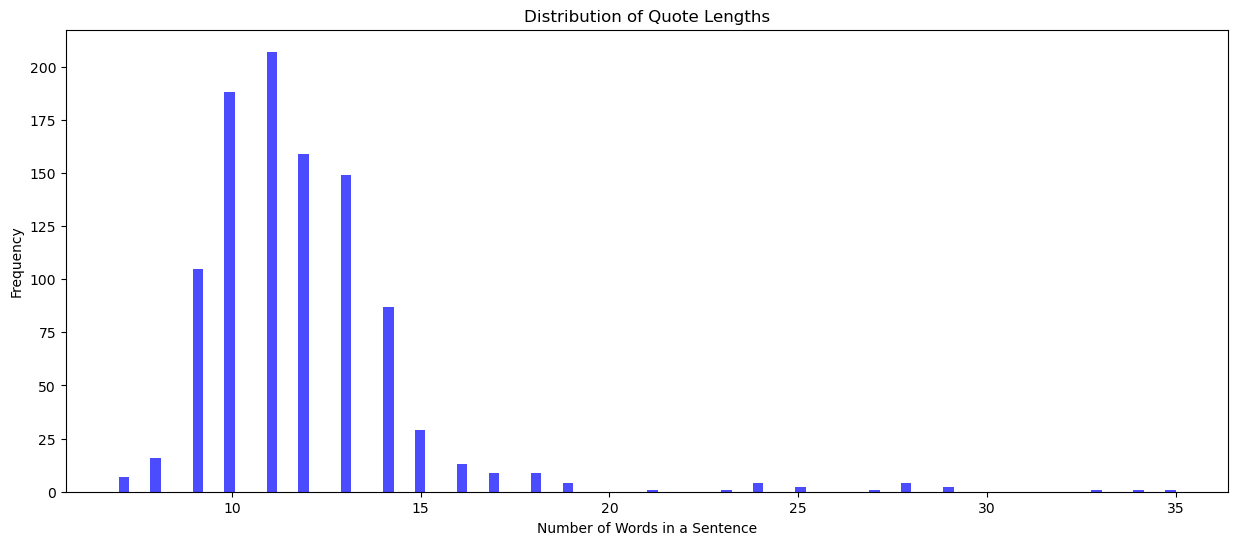

In [4]:
import matplotlib.pyplot as plt

# Assuming `data` is a list of strings (text data)
text_lengths = [len(sentence.split()) for sentence in data]

# Plotting the histogram
plt.figure(figsize=(15,6))
plt.hist(text_lengths, bins=100, color='blue', alpha=0.7)
plt.title('Distribution of Quote Lengths')
plt.xlabel('Number of Words in a Sentence')
plt.ylabel('Frequency')
plt.show()

## Removing unwanted characters / words
### Unwanted Characters
- We can safely discard __punctuations__ like (" " and .), no help in prediction of model
- Remove special characters / symbols

### Unwanted Words

- __Stop Words__: Common stop words such as “a,” “an,” “the,” “is,” “in,” and other frequently occurring words that do not carry significant meaning or predictive power.
- __Irrelevant Words__ : Identify and remove specific words that are not relevant to the prediction task or domain. For example, if you are predicting movie genres, words like “movie” or “film” may not provide helpful information.

In [259]:
# # Create a translation table
# translation_table = str.maketrans({u'\xa0': '', '\u200a': '', '"': '', '.': ''})

# # Apply the translation table to each element in the list
# data = [x.translate(translation_table) for x in data]

In [497]:
data

["Embrace the beauty of every sunrise; it's a fresh chance to paint your world with joy.",
 'Embrace challenges; they are the stepping stones to your greatest victories.',
 'Embrace the rhythm of life and let it dance through your soul.',
 'Embrace kindness, for it has the power to change the world one heart at a time.',
 'Embrace the journey, for it leads to the destination of your dreams.',
 'Embrace your uniqueness, for it is the fingerprint of your soul on the universe.',
 'Embrace the present moment, for it is the only one that truly exists.',
 'Embrace your fears, for they hold the key to unlocking your true potential.',
 'Embrace gratitude, and watch how it multiplies the blessings in your life.',
 'Embrace the rain, for it nourishes the seeds of your future success.',
 'Embrace the whispers of your heart; they carry the wisdom of the universe.',
 'Embrace laughter, for it is the music of a joyful heart.',
 'Embrace the power of forgiveness, for it sets you free from the chains 

## Checking for OOV (Out Of Vocabulary words)

In [6]:
# Train a ByteLevelBPETokenizer on the data
tokenizer_BPE = ByteLevelBPETokenizer()
tokenizer_BPE.train_from_iterator(data)

# Get the vocabulary
vocab = set(tokenizer_BPE.get_vocab().keys())
    
# Check each sentence in the data for OOV words
for sentence in data:
    tokens = tokenizer_BPE.encode(sentence).tokens
    oov_words = [word for word in tokens if word not in vocab]
    
    if oov_words:
        print(f"OOV words in sentence '{sentence}': {oov_words}")
    else:
        pass

## Tokenization
- for our case, we could try __retaining punctuations like " ' " and " ; " since they may carry certain information/ sentence structure related info__

In [7]:
# Tokenisation.



# Instantiate a Tokenizer object with custom filters
tokenizer = Tokenizer(filters='!"#$%&()*+-.:<=>?@[\\]^_`{|}~\t\n')

# Fit your Tokenizer on your dataset
tokenizer.fit_on_texts(data)

# Display the word index
print(tokenizer.word_index)

# Calculate the total number of words
total_words = len(tokenizer.word_index) + 1  # Because index 0 is reserved for padding.
print("words:", total_words)

{'the': 1, 'of': 2, 'your': 3, 'and': 4, 'a': 5, 'in': 6, 'is': 7, 'for': 8, 'let': 9, 'be': 10, 'it': 11, 'to': 12, 'every': 13, 'you': 14, 'our': 15, 'that': 16, 'dance': 17, "life's": 18, 'embrace': 19, 'through': 20, 'this': 21, 'with': 22, 'believe': 23, 'are': 24, 'radiate': 25, 'yourself,': 26, 'heart': 27, 'morning,': 28, 'will': 29, "planet's": 30, 'they': 31, 'love': 32, 'life': 33, "singapore's": 34, 'symphony': 35, 'we': 36, 'power': 37, 'from': 38, 'kindness': 39, 'find': 40, 'dreams': 41, 'soul': 42, 'world': 43, 'act': 44, 'light': 45, 'singapore,': 46, 'planet': 47, 'way': 48, 'beauty': 49, 'journey': 50, 'nature': 51, 'colors': 52, 'strength': 53, 'whispers': 54, 'canvas': 55, 'joy': 56, 'gratitude': 57, 'where': 58, 'spirit': 59, 'true': 60, 'beacon': 61, 'towards': 62, 'hold': 63, 'potential': 64, 'hearts': 65, 'testament': 66, 'morning': 67, 'future': 68, 'new': 69, 'heartbeat': 70, 'actions': 71, 'promise': 72, 'force': 73, 'others': 74, 'step': 75, 'compass': 76, 

### Distribution / Count of words

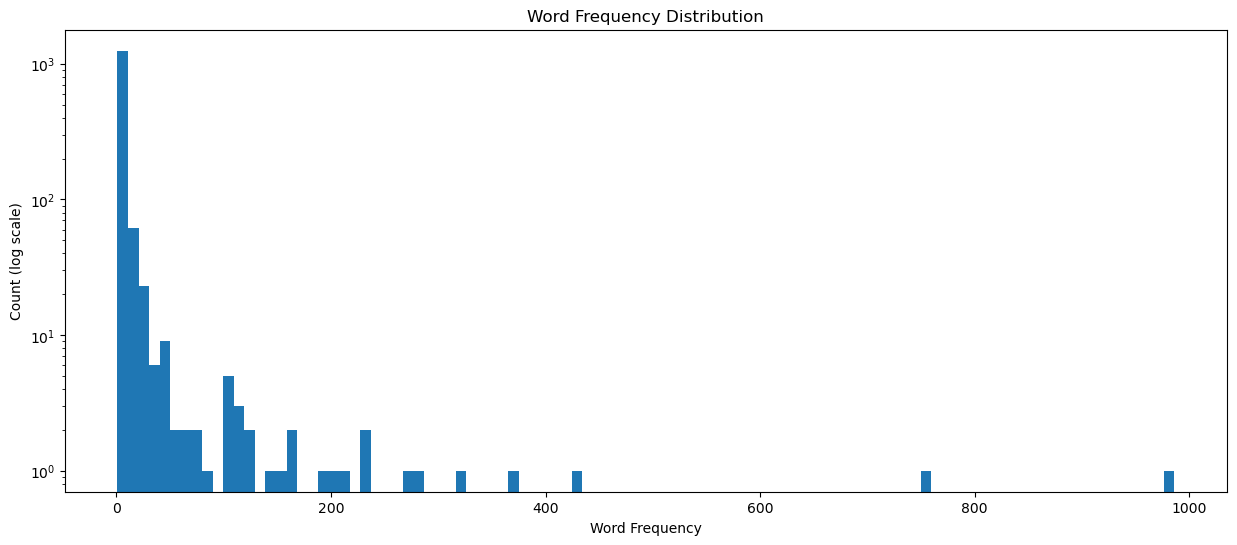

In [8]:
# Get word frequencies from the Tokenizer
word_frequencies = list(tokenizer.word_counts.values())
# Plot histogram
plt.figure(figsize=(15, 6))
plt.hist(word_frequencies, bins=100, log=True)
plt.title('Word Frequency Distribution')
plt.xlabel('Word Frequency')
plt.ylabel('Count (log scale)')
plt.show()

In [9]:
# Under the Tokenizer object, you can convert texts to sequences of integers.
# Be careful of the indexing of your data list, and how you use the ".texts_to_sequences" method.

print(data[0])
print(tokenizer.texts_to_sequences([data[0]])[0])
print()

print(data[1])
print(tokenizer.texts_to_sequences([data[1]])[0])
print()

print(data[2])
print(tokenizer.texts_to_sequences([data[2]])[0]) #There is this extra [0] at the end, because the output is a list of list.
print()

Embrace the beauty of every sunrise; it's a fresh chance to paint your world with joy.
[19, 1, 49, 2, 13, 765, 421, 5, 173, 550, 12, 99, 3, 43, 22, 56]

Embrace challenges; they are the stepping stones to your greatest victories.
[19, 766, 31, 24, 1, 422, 551, 12, 3, 423, 767]

Embrace the rhythm of life and let it dance through your soul.
[19, 1, 100, 2, 33, 4, 9, 11, 17, 20, 3, 42]



## Text Vectorization

In [140]:
# Convert quotes from text to integer
input_sequence = []

for datapoint in data:
    token_list = tokenizer.texts_to_sequences([datapoint])[0] # Again, this extra [0] is because the output
                                                              # is a list of list.
    input_sequence.append(token_list)

print(f'Total number of quotes: {len(input_sequence)}')


Total number of quotes: 1000


In [129]:

input_sequences = []
for line in data:
    token_list = tokenizer.texts_to_sequences([line])[0]
    #print(token_list)
    
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

# print(input_sequences)
print("Total input sequences: ", len(input_sequences))

Total input sequences:  10886


## Generating more Input-Output pairs + Padding for same length

In [139]:
input_sequence_sorted = sorted(input_sequence, key=len)
input_sequence_sorted

[[23, 6, 26, 4, 364, 29, 867],
 [23, 6, 26, 4, 156, 29, 457],
 [34, 471, 499, 22, 49, 4, 293],
 [34, 109, 1110, 22, 108, 4, 41],
 [46, 58, 120, 316, 145, 4, 194],
 [46, 58, 120, 4, 1192, 141, 702],
 [46, 58, 697, 4, 120, 141, 702],
 [25, 204, 8, 11, 7, 589, 4, 188],
 [23, 6, 26, 4, 14, 29, 10, 866],
 [23, 6, 26, 4, 114, 3, 41, 235],
 [23, 6, 26, 4, 14, 29, 206, 74],
 [23, 6, 26, 4, 9, 3, 59, 250],
 [23, 6, 26, 4, 14, 29, 25, 290],
 [23, 6, 26, 8, 3, 64, 7, 878],
 [23, 6, 26, 4, 14, 29, 604, 246],
 [18, 219, 24, 112, 6, 910, 19, 461],
 [17, 20, 18, 219, 22, 462, 4, 120],
 [13, 396, 7, 5, 397, 8, 5, 498],
 [13, 396, 7, 5, 397, 8, 5, 498],
 [46, 58, 671, 1082, 4, 41, 190, 249],
 [6, 34, 1087, 41, 1088, 8, 1, 366],
 [46, 58, 463, 4, 1151, 141, 1, 68],
 [46, 58, 697, 4, 1179, 141, 1, 68],
 [25, 204, 4, 114, 176, 11, 445, 3, 43],
 [25, 277, 8, 11, 142, 1, 45, 2, 432],
 [25, 242, 4, 40, 161, 6, 212, 154, 7],
 [25, 242, 4, 40, 161, 6, 212, 154, 7],
 [25, 281, 4, 114, 176, 11, 591, 452, 592],
 

### Function: Generate I/O pairs 

In [476]:
def generate_input_output_pairs(input_sequence, n):
    input_output_pair = set()  # Use a set to store unique pairs

    for datapoint in input_sequence:
        if len(datapoint) >= n:
            for i in range(len(datapoint) - (n - 1)):
                pair = tuple(datapoint[i:i + n])
                input_output_pair.add(pair)

    return list(input_output_pair)  # Convert set back to a list for further processing





### Generating and Padding Input Output Pairs
- here, we iterate through till the __max sequence length of our data (35)__, considering every possible __list of 2 to n words__, where n is the sequence length (if the length of each quote exceeds n, we stop producing pairs from that quote)
- i decided to try padding up till __20 words__, as since we are mainly predicting next __10 words__ / shorter quotes,however,while saving training time, we may lose information on the longer input sequences > 20 words

In [477]:
input_output_pairs = []
sequence_len = 0

for i in range(2, 36, 1):  # Max no. of word length in our dataset
    pairs = generate_input_output_pairs(input_sequence, i)
    input_output_pairs.extend(pairs)
    max_sequence_len = max([len(x) for x in input_output_pairs]) # This is to get the longest sequence of texts. 


# Pad all input-output pairs to the same length
input_output_pairs_padded = np.array(pad_sequences(input_output_pairs, maxlen=35, padding='pre'))

print(input_output_pairs_padded)
print(max_sequence_len)


[[   0    0    0 ...    0    2  567]
 [   0    0    0 ...    0   18   17]
 [   0    0    0 ...    0   13   88]
 ...
 [   0   44    2 ...  224    4 1074]
 [   0   13   44 ...    2  224    4]
 [  13   44    2 ...  224    4 1074]]
35


### Double check for duplicated input-out pairs (unique)

In [478]:

# Convert each list to a tuple and use set to find duplicates
duplicates = [list(item) for item in set(tuple(lst) for lst in input_output_pairs) if input_output_pairs.count(list(item)) > 1]

# Print duplicates
print("Exact duplicates within each list:")
for duplicate in duplicates:
    print(duplicate)

Exact duplicates within each list:


## Prepare features and labels

In [479]:
# Now that we have an array, let us slice the last word as the output.
# The preceding words are the input.

X = input_output_pairs_padded[:,:-1]
y = input_output_pairs_padded[:,-1]
print(X)
print("")
print(y)

[[  0   0   0 ...   0   0   2]
 [  0   0   0 ...   0   0  18]
 [  0   0   0 ...   0   0  13]
 ...
 [  0  44   2 ...   2 224   4]
 [  0  13  44 ...  78   2 224]
 [ 13  44   2 ...   2 224   4]]

[ 567   17   88 ... 1074    4 1074]


### Splitting to Validation and Train sets

In [491]:
from sklearn.model_selection import train_test_split

# Assuming input_output_pairs_padded is your data
X = input_output_pairs_padded[:, :-1]
y = input_output_pairs_padded[:, -1]

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes to verify
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

X_train shape: (36007, 34)
y_train shape: (36007,)
X_val shape: (9002, 34)
y_val shape: (9002,)


## One-hot encoding

In [492]:
from tensorflow.keras import utils
y_train = utils.to_categorical(y_train, num_classes=total_words)
y_val = utils.to_categorical(y_val, num_classes=total_words)
print(y_train)
print(y_val)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [493]:

print(total_words)
print(X_train.shape)
print(y_train.shape)

print(X_val.shape)
print(y_val.shape)

1384
(36007, 34)
(36007, 1384)
(9002, 34)
(9002, 1384)


# Modelling

## Function: Model Accuracy and Loss

In [483]:
def plot_graphs_acc(history,title):
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel('Accuracies')
    plt.title(title)
    plt.show()

def plot_graphs_loss(history,title):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel('Loss')
    plt.title(title)
    plt.show()


## Function: Predict Next N words (with randomness)

### Higher Temperature (e.g., > 1.0):

Increases randomness.

Softens the probability distribution, making less probable words more likely to be chosen.

Results in more diverse but potentially less coherent/generated text.

### Lower Temperature (e.g., < 1.0):

Reduces randomness.

Sharpens the probability distribution, making high-probability words more likely to be chosen.

Results in more focused but potentially repetitive/generated text.


#### _Basically adjusts the shape of the probability distribution used to sample the next word._

In [484]:
def predict_next_N_words(model, input_text, N_words=10, input_length=max_sequence_len-1, temperature=1.0):

    generated_text = input_text
    if temperature <= 0:
        return "Temperature should be greater than 0"
    for _ in range(N_words):
        tokens = tokenizer.texts_to_sequences([input_text])[0]
        tokens = pad_sequences([tokens], maxlen=input_length, padding='pre')
        prediction = model.predict(tokens, verbose=0)[0]

        # Adjust temperature for more or less randomness
        prediction = np.log(prediction) / temperature
        exp_preds = np.exp(prediction)
        prediction = exp_preds / np.sum(exp_preds)

        # Sample from the probability distribution with some randomness 
        predicted_index = np.random.choice(len(prediction), p=prediction)
        predicted_word = tokenizer.index_word.get(predicted_index, '')

        generated_text += " " + predicted_word
        input_text += " " + predicted_word  # Update the input text for the next prediction

    return generated_text






## Function: Test on seed_texts

In [485]:
def test_on_seed_texts(model,N_words = 10,input_length = max_sequence_len-1,temperature=0):
    seed_texts = ['embrace each day',
                'radiate some',
                'believe that',
                "life's actual purpose is",
                'dance through each and every',
                'let your time and energy',
                'every person is',
                'our country Singapore is','planet earth is',
                'morning and evening would make it']
    predicted_text_list = []
    for input_text in seed_texts:
        predicted_text = predict_next_N_words(model,input_text, N_words,input_length,temperature)
        predicted_text_list.append(predicted_text)
        #print(predicted_text)
    
    return predicted_text_list

## Training Simple RNN Model

In [206]:
RNN_base= Sequential()
RNN_base.add(Embedding(total_words, 100, input_length=20-1))
RNN_base.add(SimpleRNN(256))
RNN_base.add(Dense(total_words, activation='softmax'))
RNN_base.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
)
model_checkpoint_RNN = ModelCheckpoint('Models_RNN/RNN_base.h5',save_best_only=True)

history_RNN_base = RNN_base.fit(X_train,y_train, epochs=50,batch_size=128,verbose=1,validation_data=(X_val,y_val),shuffle=True,callbacks=[early_stopping,model_checkpoint_RNN])
#print 
print(RNN_base)

Epoch 1/50
428/428 [==============================] - ETA: 0s - loss: 4.5350 - accuracy: 0.2263INFO:tensorflow:Assets written to: Models_RNN\RNN_base\assets


INFO:tensorflow:Assets written to: Models_RNN\RNN_base\assets


428/428 [==============================] - 15s 33ms/step - loss: 4.5350 - accuracy: 0.2263 - val_loss: 3.2225 - val_accuracy: 0.3784
Epoch 2/50
427/428 [============================>.] - ETA: 0s - loss: 2.5718 - accuracy: 0.4776INFO:tensorflow:Assets written to: Models_RNN\RNN_base\assets


INFO:tensorflow:Assets written to: Models_RNN\RNN_base\assets


428/428 [==============================] - 15s 36ms/step - loss: 2.5713 - accuracy: 0.4776 - val_loss: 2.0770 - val_accuracy: 0.5631
Epoch 3/50
428/428 [==============================] - ETA: 0s - loss: 1.7269 - accuracy: 0.6219INFO:tensorflow:Assets written to: Models_RNN\RNN_base\assets


INFO:tensorflow:Assets written to: Models_RNN\RNN_base\assets


428/428 [==============================] - 15s 36ms/step - loss: 1.7269 - accuracy: 0.6219 - val_loss: 1.5600 - val_accuracy: 0.6550
Epoch 4/50
427/428 [============================>.] - ETA: 0s - loss: 1.3241 - accuracy: 0.6938INFO:tensorflow:Assets written to: Models_RNN\RNN_base\assets


INFO:tensorflow:Assets written to: Models_RNN\RNN_base\assets


428/428 [==============================] - 16s 38ms/step - loss: 1.3241 - accuracy: 0.6938 - val_loss: 1.3213 - val_accuracy: 0.6956
Epoch 5/50
427/428 [============================>.] - ETA: 0s - loss: 1.1124 - accuracy: 0.7303INFO:tensorflow:Assets written to: Models_RNN\RNN_base\assets


INFO:tensorflow:Assets written to: Models_RNN\RNN_base\assets


428/428 [==============================] - 14s 33ms/step - loss: 1.1124 - accuracy: 0.7303 - val_loss: 1.1710 - val_accuracy: 0.7156
Epoch 6/50
428/428 [==============================] - ETA: 0s - loss: 0.9964 - accuracy: 0.7491INFO:tensorflow:Assets written to: Models_RNN\RNN_base\assets


INFO:tensorflow:Assets written to: Models_RNN\RNN_base\assets


428/428 [==============================] - 13s 31ms/step - loss: 0.9964 - accuracy: 0.7491 - val_loss: 1.0902 - val_accuracy: 0.7356
Epoch 7/50
427/428 [============================>.] - ETA: 0s - loss: 0.9255 - accuracy: 0.7589INFO:tensorflow:Assets written to: Models_RNN\RNN_base\assets


INFO:tensorflow:Assets written to: Models_RNN\RNN_base\assets


428/428 [==============================] - 13s 29ms/step - loss: 0.9256 - accuracy: 0.7589 - val_loss: 1.0500 - val_accuracy: 0.7440
Epoch 8/50
428/428 [==============================] - ETA: 0s - loss: 0.8798 - accuracy: 0.7666INFO:tensorflow:Assets written to: Models_RNN\RNN_base\assets


INFO:tensorflow:Assets written to: Models_RNN\RNN_base\assets


428/428 [==============================] - 14s 33ms/step - loss: 0.8798 - accuracy: 0.7666 - val_loss: 1.0195 - val_accuracy: 0.7488
Epoch 9/50
427/428 [============================>.] - ETA: 0s - loss: 0.8448 - accuracy: 0.7719INFO:tensorflow:Assets written to: Models_RNN\RNN_base\assets


INFO:tensorflow:Assets written to: Models_RNN\RNN_base\assets


428/428 [==============================] - 14s 32ms/step - loss: 0.8444 - accuracy: 0.7720 - val_loss: 1.0067 - val_accuracy: 0.7499
Epoch 10/50
427/428 [============================>.] - ETA: 0s - loss: 0.8229 - accuracy: 0.7739INFO:tensorflow:Assets written to: Models_RNN\RNN_base\assets


INFO:tensorflow:Assets written to: Models_RNN\RNN_base\assets


428/428 [==============================] - 14s 32ms/step - loss: 0.8232 - accuracy: 0.7739 - val_loss: 0.9879 - val_accuracy: 0.7526
Epoch 11/50
426/428 [============================>.] - ETA: 0s - loss: 0.8053 - accuracy: 0.7791INFO:tensorflow:Assets written to: Models_RNN\RNN_base\assets


INFO:tensorflow:Assets written to: Models_RNN\RNN_base\assets


428/428 [==============================] - 13s 31ms/step - loss: 0.8057 - accuracy: 0.7790 - val_loss: 0.9865 - val_accuracy: 0.7549
Epoch 12/50
428/428 [==============================] - ETA: 0s - loss: 0.7977 - accuracy: 0.7787INFO:tensorflow:Assets written to: Models_RNN\RNN_base\assets


INFO:tensorflow:Assets written to: Models_RNN\RNN_base\assets


428/428 [==============================] - 14s 33ms/step - loss: 0.7977 - accuracy: 0.7787 - val_loss: 0.9816 - val_accuracy: 0.7549
Epoch 13/50
428/428 [==============================] - ETA: 0s - loss: 0.7856 - accuracy: 0.7794INFO:tensorflow:Assets written to: Models_RNN\RNN_base\assets


INFO:tensorflow:Assets written to: Models_RNN\RNN_base\assets


428/428 [==============================] - 14s 32ms/step - loss: 0.7856 - accuracy: 0.7794 - val_loss: 0.9760 - val_accuracy: 0.7542
Epoch 14/50
427/428 [============================>.] - ETA: 0s - loss: 0.7785 - accuracy: 0.7815INFO:tensorflow:Assets written to: Models_RNN\RNN_base\assets


INFO:tensorflow:Assets written to: Models_RNN\RNN_base\assets


428/428 [==============================] - 14s 32ms/step - loss: 0.7784 - accuracy: 0.7815 - val_loss: 0.9700 - val_accuracy: 0.7600
Epoch 15/50
428/428 [==============================] - 12s 29ms/step - loss: 0.7744 - accuracy: 0.7811 - val_loss: 0.9785 - val_accuracy: 0.7567
Epoch 16/50
427/428 [============================>.] - ETA: 0s - loss: 0.7720 - accuracy: 0.7809INFO:tensorflow:Assets written to: Models_RNN\RNN_base\assets


INFO:tensorflow:Assets written to: Models_RNN\RNN_base\assets


428/428 [==============================] - 13s 30ms/step - loss: 0.7721 - accuracy: 0.7808 - val_loss: 0.9680 - val_accuracy: 0.7588
Epoch 17/50
428/428 [==============================] - 12s 27ms/step - loss: 0.7644 - accuracy: 0.7827 - val_loss: 0.9714 - val_accuracy: 0.7553
Epoch 18/50
428/428 [==============================] - 13s 30ms/step - loss: 0.7612 - accuracy: 0.7829 - val_loss: 0.9730 - val_accuracy: 0.7574
Epoch 19/50
428/428 [==============================] - 13s 30ms/step - loss: 0.7595 - accuracy: 0.7827 - val_loss: 0.9804 - val_accuracy: 0.7577
Epoch 20/50
428/428 [==============================] - 13s 29ms/step - loss: 0.7561 - accuracy: 0.7837 - val_loss: 0.9795 - val_accuracy: 0.7567
Epoch 21/50
428/428 [==============================] - 13s 30ms/step - loss: 0.7545 - accuracy: 0.7834 - val_loss: 0.9808 - val_accuracy: 0.7630


### Evaluating On Acc and Val Acc

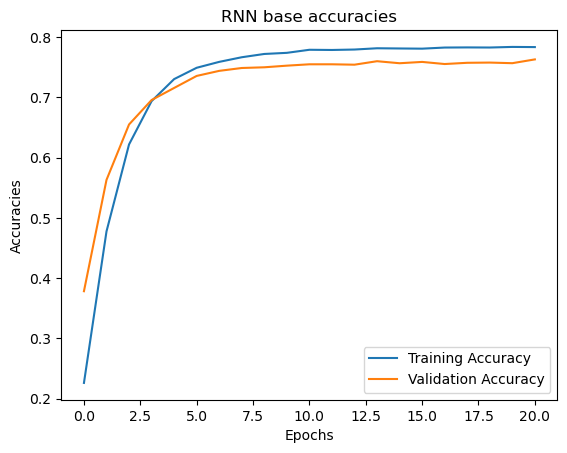

In [207]:
plot_graphs_acc(history_RNN_base,'RNN base accuracies')

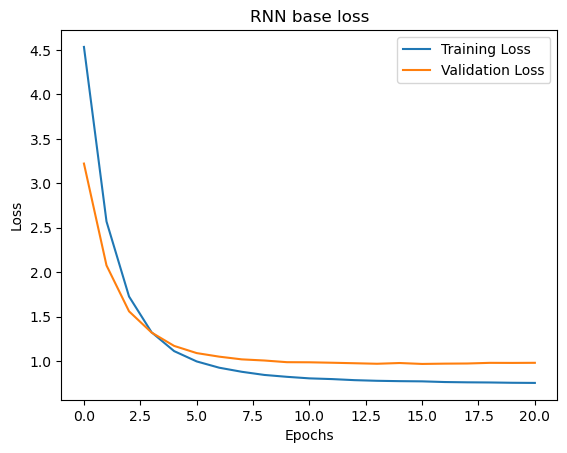

In [208]:
plot_graphs_loss(history_RNN_base,'RNN base loss')

In [382]:
RNN_pred = test_on_seed_texts(RNN_base,10,19,0.2)


embrace each day a life secrets bring life     
radiate some hear for it is the intuition of where strength and
believe that serenity your journey for a challenges future of our singapore
life's actual purpose is a lives of the strength in our connect and innovation
dance through each and every new symphony passions resilience our soul and guides and unwavering
let your time and energy for promise to midst and     
every person is a pulse of the world its you more is a
our country Singapore is a authenticity that halls self make comeback   
planet earth is others leaves in your future connection our singapore destiny the
morning and evening would make it is the opportunities of a shape morning be the heartbeat


In [383]:
from keras.preprocessing.text import Tokenizer
from keras_nlp.metrics import Bleu
from nltk.translate.bleu_score import sentence_bleu

# Original data
actual_quotes = data  # Replace [...] with your actual data

# Predicted list

# Seed texts
seed_texts = ['embrace each day',
              'radiate some',
              'believe that',
              "life's actual purpose is",
              'dance through each and every',
              'let your time and energy',
              'every person is',
              'our country Singapore is',
              'planet earth is',
              'morning and evening would make it']

# Tokenize actual quotes and predicted text using Keras Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(actual_quotes)
actual_quotes_tokenized = input_sequence

predicted_list_tokenized = [tokenizer.texts_to_sequences([RNN_pred])[0] for predicted_text in RNN_pred]

# Function to split data into chunks of 100 lines
def chunk_data(data, chunk_size=100):
    chunks = [data[i:i + chunk_size] for i in range(0, len(data), chunk_size)]
    return chunks

# Compute BLEU score for each seed text and prediction
for seed_text, predicted_text in zip(seed_texts, predicted_list_tokenized):
    # Find the index of the seed text in the list
    seed_index = seed_texts.index(seed_text)
    
    # Retrieve the corresponding chunk of 100 quotes
    actual_chunk = actual_quotes_tokenized[seed_index * 100: (seed_index + 1) * 100]

    # Convert tokenized quotes back to strings
    actual_chunk_strings = [" ".join(map(str, quote)) for quote in actual_chunk]
    
    predicted_text_string = " ".join(map(str, predicted_text))
    print([actual_chunk_strings][0], 'asd',predicted_text_string)
    # Compute BLEU score for the chunk
    bleu_score = sentence_bleu([actual_chunk_strings], predicted_text_string)
    print(f"BLEU Score for '{seed_text}': {round(bleu_score, 3)}")


['19 1 49 2 13 765 421 5 173 550 12 99 3 43 22 56', '19 766 31 24 1 422 551 12 3 423 767', '19 1 100 2 33 4 9 11 17 20 3 42', '19 174 8 11 149 1 37 12 90 1 43 424 27 552 5 425', '19 1 263 8 11 264 12 1 768 2 3 41', '19 3 769 8 11 7 1 770 2 3 42 86 1 150', '19 1 228 553 8 11 7 1 554 424 16 335 771', '19 3 426 8 31 63 1 175 12 336 3 60 64', '19 91 4 114 176 11 555 1 134 6 3 33', '19 1 229 8 11 427 1 101 2 3 68 135', '19 1 54 2 3 556 31 177 1 92 2 1 150', '19 557 8 11 7 1 122 2 5 151 27', '19 1 37 2 178 8 11 428 14 337 38 1 558 2 1 429', '19 1 772 11 773 430 198 338 339 559', '19 1 774 560 8 31 775 63 1 423 776', '19 179 8 11 7 1 230 2 1 42', '19 231 8 11 7 1 554 777 6 18 340 778', '19 1 779 8 11 80 1 72 2 69 152', '19 3 431 8 31 24 1 561 2 3 93', '19 1 52 2 180 232 6 1 780 2 1 233 234', '19 136 8 11 7 1 562 2 60 53', '19 563 8 11 7 1 564 12 5 781 27', '19 1 37 2 5 341 565 11 123 45 153 1 43', '19 1 92 2 782 8 11 7 1 137 566 2 432', '19 783 8 11 784 1 150 12 235 6 181 342 425', '19 1 94 2

## Using BLEU metrics to evaluate our generated texts

In [494]:
from keras_nlp.metrics import BLEU

# Example actual quotes and generated text
actual_quotes = data 

generated_text = "Your generated text here."

# Tokenize actual quotes and generated text
actual_quotes_tokenized = [quote.split() for quote in actual_quotes]
generated_text_tokenized = generated_text.split()

# Initialize BLEU scorer
bleu_scorer = BLEU()

# Compute BLEU score
bleu_score = bleu_scorer.compute_score(reference_list=[actual_quotes_tokenized], hypothesis_list=[generated_text_tokenized])

print(f"BLEU Score: {bleu_score[0][0]}")


ImportError: cannot import name 'BLEU' from 'keras_nlp.metrics' (c:\Users\wilfr\anaconda3\envs\gpu_env\lib\site-packages\keras_nlp\metrics\__init__.py)

## Training GRU Model

In [431]:

GRU_base= Sequential()
GRU_base.add(Embedding(total_words, 100, input_length=20-1))  # Corrected input_length
GRU_base.add(GRU(256))  # Replace SimpleRNN with GRU
GRU_base.add(Dense(total_words, activation='softmax'))
GRU_base.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
)

model_checkpoint_GRU = ModelCheckpoint('Models_RNN/GRU_base.h5', save_best_only=True)

history_GRU_base = GRU_base.fit(X_train, y_train, epochs=50, batch_size=128, verbose=1, validation_data=(X_val, y_val), shuffle=True, callbacks=[early_stopping, model_checkpoint_GRU])

# Print the model summary
GRU_base.summary()

Epoch 1/50
428/428 [==============================] - 68s 154ms/step - loss: 4.5771 - accuracy: 0.2198 - val_loss: 3.2704 - val_accuracy: 0.3664
Epoch 2/50
428/428 [==============================] - 205s 481ms/step - loss: 2.6072 - accuracy: 0.4655 - val_loss: 2.0809 - val_accuracy: 0.5535
Epoch 3/50
428/428 [==============================] - 8s 19ms/step - loss: 1.7251 - accuracy: 0.6103 - val_loss: 1.5502 - val_accuracy: 0.6477
Epoch 4/50
428/428 [==============================] - 12s 29ms/step - loss: 1.3125 - accuracy: 0.6876 - val_loss: 1.2912 - val_accuracy: 0.7005
Epoch 5/50
428/428 [==============================] - 8s 19ms/step - loss: 1.1003 - accuracy: 0.7269 - val_loss: 1.1802 - val_accuracy: 0.7191
Epoch 6/50
428/428 [==============================] - 8s 19ms/step - loss: 0.9835 - accuracy: 0.7473 - val_loss: 1.0881 - val_accuracy: 0.7303
Epoch 7/50
428/428 [==============================] - 8s 18ms/step - loss: 0.9096 - accuracy: 0.7587 - val_loss: 1.0360 - val_accuracy: 

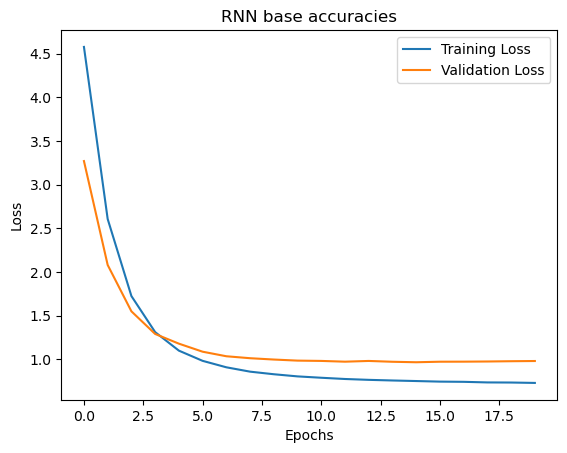

In [433]:
plot_graphs_loss(history_GRU_base,'RNN base accuracies')

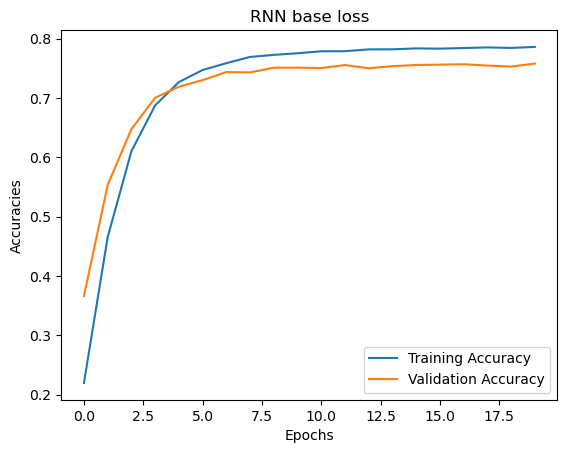

In [434]:
plot_graphs_acc(history_GRU_base,'RNN base loss')

## Training LSTM Model

In [345]:
LSTM_base = Sequential()
LSTM_base.add(Embedding(input_dim=total_words, output_dim=100, input_length=20-1))
LSTM_base.add(GRU(units=256))
LSTM_base.add(Dropout(0.2))
LSTM_base.add(Dense(units=total_words, activation='softmax'))
LSTM_base.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_LSTM_base = LSTM_base.fit(X_train,y_train,validation_data=(X_val,y_val), epochs=40,batch_size=128,verbose=1)

Epoch 1/40


ValueError: in user code:

    File "c:\Users\wilfr\anaconda3\envs\gpu_env\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\wilfr\anaconda3\envs\gpu_env\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\wilfr\anaconda3\envs\gpu_env\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\wilfr\anaconda3\envs\gpu_env\lib\site-packages\keras\engine\training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\wilfr\anaconda3\envs\gpu_env\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\wilfr\anaconda3\envs\gpu_env\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_15" is incompatible with the layer: expected shape=(None, 19), found shape=(None, 20)


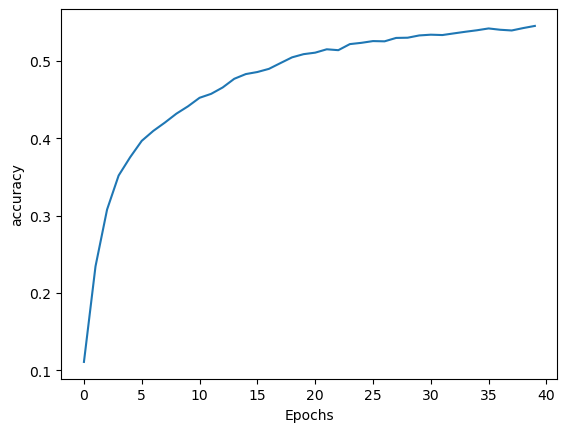

In [310]:
plot_graphs(history_LSTM_base,'accuracy')

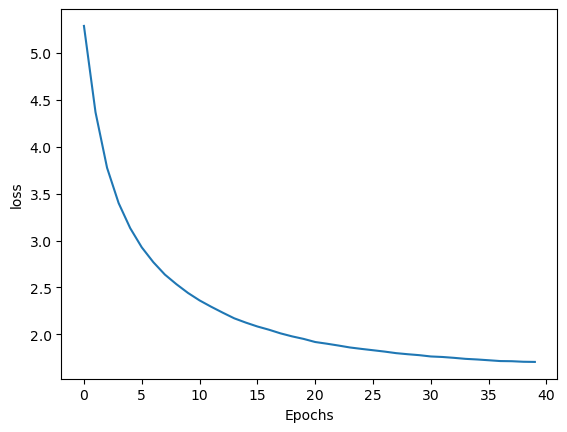

In [311]:
plot_graphs(history_LSTM_base,'loss')

In [307]:
test_on_seed_texts(LSTM_base,10,19)

embrace each day be the inner that leads you cleanses to force reflection
radiate some journey and let your morning, bukit find at and journey
believe that our nature gratitude, the whispers sunrise, is a reminder canvas,
life's actual purpose is the compass of sunrise and towards of our nature gratitude,
dance through each and every star is a reminder canvas, to force reflection of flow
let your time and energy it empathy light peace even the darkest days tapestry solace
every person is a into to force reflection of flow choice indomitable illuminates
our country Singapore is a park's of you are the expression, a garden someone's
planet earth is a reminder canvas, to joyful your blessings and beauty to
morning and evening would make it is the compass of sunrise and within for they morning


## Training Bi-LSTM Model
- BiLSTM - every component of an input sequence has information from both the past and present which can produce a more meaningful output, combining LSTM layers from both directions.

In [277]:

BiLSTM_base= Sequential()
BiLSTM_base.add(Embedding(total_words, 100, input_length=20-1))
BiLSTM_base.add(Bidirectional(LSTM(256)))
BiLSTM_base.add(Dense(total_words, activation='softmax'))
BiLSTM_base.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
)
model_checkpoint_BiLSTM = ModelCheckpoint('Models_RNN/BiLSTM_base.h5',save_best_only=True)

history_BiLSTM_base = BiLSTM_base.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=50,batch_size=128,verbose=1,callbacks=[early_stopping,model_checkpoint_BiLSTM])
#print 
print(BiLSTM_base)

Epoch 1/50
428/428 [==============================] - 19s 39ms/step - loss: 4.9583 - accuracy: 0.1458 - val_loss: 3.9743 - val_accuracy: 0.2529
Epoch 2/50
428/428 [==============================] - 16s 38ms/step - loss: 3.3465 - accuracy: 0.3447 - val_loss: 2.8261 - val_accuracy: 0.4084
Epoch 3/50
428/428 [==============================] - 12s 28ms/step - loss: 2.4998 - accuracy: 0.4621 - val_loss: 2.2776 - val_accuracy: 0.5039
Epoch 4/50
428/428 [==============================] - 12s 28ms/step - loss: 2.0205 - accuracy: 0.5442 - val_loss: 1.9191 - val_accuracy: 0.5654
Epoch 5/50
428/428 [==============================] - 18s 43ms/step - loss: 1.7007 - accuracy: 0.6033 - val_loss: 1.6690 - val_accuracy: 0.6159
Epoch 6/50
428/428 [==============================] - 17s 40ms/step - loss: 1.4772 - accuracy: 0.6445 - val_loss: 1.4813 - val_accuracy: 0.6526
Epoch 7/50
428/428 [==============================] - 14s 32ms/step - loss: 1.3091 - accuracy: 0.6779 - val_loss: 1.3614 - val_accuracy:

In [495]:
BiLSTM_base.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 19, 100)           138400    
                                                                 
 bidirectional_2 (Bidirectio  (None, 512)              731136    
 nal)                                                            
                                                                 
 dense_14 (Dense)            (None, 1384)              709992    
                                                                 
Total params: 1,579,528
Trainable params: 1,579,528
Non-trainable params: 0
_________________________________________________________________


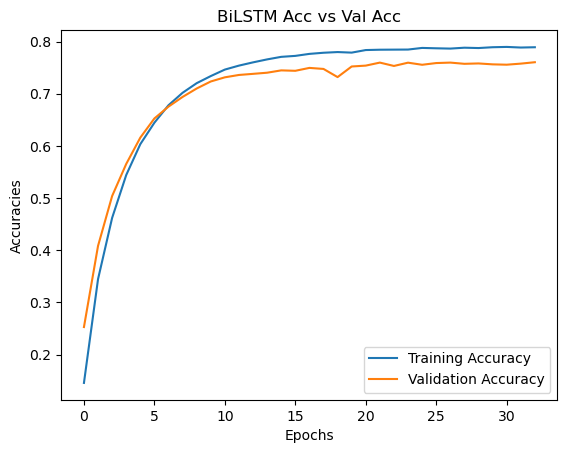

In [496]:
plot_graphs_acc(history_BiLSTM_base,'BiLSTM Acc vs Val Acc')

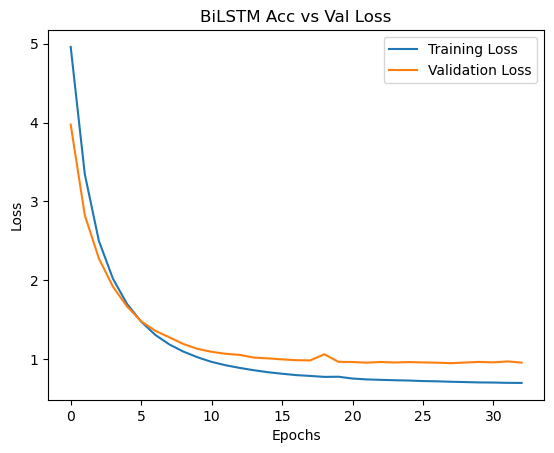

In [280]:
plot_graphs_loss(history_BiLSTM_base,'BiLSTM Acc vs Val Loss')

## Evaluate Model on seed text 


In [393]:
predicted_list = test_on_seed_texts(BiLSTM_base,10,20-1,0.4)



embrace each day a tapestry of we that this hold protect the testament
radiate some humility and let it be the leave of your fuel
believe that you resilience away to character brilliance comes to day the
life's actual purpose is for it is the proof to compassion positivity and shine
dance through each and every new is a heartbeats of souls is a new resilience
let your time and energy for the tread a towards to fresh artistry and one
every person is a wind of colors in the morning of this heart
our country Singapore is the nights power marina life conductor state the days merlion
planet earth is a weave for experiences is the written of our carry
morning and evening would make it is the presence of a own learning find and presents


In [395]:
predicted_list

['embrace each day a tapestry of we that this hold protect the testament',
 'radiate some humility and let it be the leave of your fuel',
 'believe that you resilience away to character brilliance comes to day the',
 "life's actual purpose is for it is the proof to compassion positivity and shine",
 'dance through each and every new is a heartbeats of souls is a new resilience',
 'let your time and energy for the tread a towards to fresh artistry and one',
 'every person is a wind of colors in the morning of this heart',
 'our country Singapore is the nights power marina life conductor state the days merlion',
 'planet earth is a weave for experiences is the written of our carry',
 'morning and evening would make it is the presence of a own learning find and presents']

## Using BLEU metrics to evaluate our generated texts

In [405]:
from keras.preprocessing.text import Tokenizer
from keras_nlp.metrics import Bleu
from nltk.translate.bleu_score import sentence_bleu

# Original data
actual_quotes = data  # Replace [...] with your actual data

# Predicted list

# Seed texts
seed_texts = ['embrace each day',
              'radiate some',
              'believe that',
              "life's actual purpose is",
              'dance through each and every',
              'let your time and energy',
              'every person is',
              'our country Singapore is',
              'planet earth is',
              'morning and evening would make it']

# Tokenize actual quotes and predicted text using Keras Tokenizer

actual_quotes_tokenized = input_sequence
predicted_list_tokenized = [tokenizer.texts_to_sequences([predicted_text])[0] for predicted_text in predicted_list]

# Function to split data into chunks of 100 lines
def chunk_data(data, chunk_size=100):
    chunks = [data[i:i + chunk_size] for i in range(0, len(data), chunk_size)]
    return chunks

# Compute BLEU score for each seed text and prediction
for seed_index, seed_text in enumerate(seed_texts):
    # Retrieve the corresponding chunk of 100 quotes
    actual_chunk = actual_quotes_tokenized[seed_index * 100: (seed_index + 1) * 100]

    # Convert tokenized quotes back to strings
    actual_chunk_strings = [" ".join(map(str, quote)) for quote in actual_chunk]
    
    predicted_text_string = " ".join(map(str, predicted_list_tokenized[seed_index]))
    
    # Compute BLEU score for the chunk
    bleu_score = sentence_bleu([actual_chunk_strings], predicted_text_string)
    
    print(f"BLEU Score for '{seed_text}': {round(bleu_score, 3)}")

BLEU Score for 'embrace each day': 0
BLEU Score for 'radiate some': 0
BLEU Score for 'believe that': 0
BLEU Score for 'life's actual purpose is': 0
BLEU Score for 'dance through each and every': 0
BLEU Score for 'let your time and energy': 0
BLEU Score for 'every person is': 0
BLEU Score for 'our country Singapore is': 0
BLEU Score for 'planet earth is': 0
BLEU Score for 'morning and evening would make it': 0


In [403]:

bleu_score = sentence_bleu(['embrace each day a tapestry of we that this hold protect the testament'],['embrace each'])
bleu_score

0

## Improved BiLSTM
- Model is over-fitting, we can add __Regularizer / Dropout__

## Callbacks to generate text 

In [501]:
from tensorflow.keras.callbacks import LambdaCallback

import sys
import random
maxlen = 35
# Convert each quote to lowercase
lowercase_data = [quote.lower() for quote in data]
text = ' '.join(lowercase_data)
chars = sorted(list(set(text)))

char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

def on_epoch_end(epoch, logs):
    # Function invoked at end of each epoch. Prints generated text.
    print()
    print('----- Generating text after Epoch: %d' % epoch)

    start_index = random.randint(0, len(text) - maxlen - 1)
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print('----- diversity:', diversity)

        generated = ''
        sentence = text[start_index: start_index + maxlen]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(400):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.

            preds = Model1.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)


### Learning Rate Decay


In [502]:
lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9)

### Fitting Model 
- Here we try two different Optimizers, __RMSprop and Adam__ with Learning rate decay
- We can observe that __RMSprop__ actually gave us a better train acc while overfitting more compared to __Adam__

In [506]:
from tensorflow.keras.optimizers import SGD, Adam, RMSprop

# Define the optimizers to test along with their learning rates
optimizers = {'adam': Adam(learning_rate=lr_scheduler), 'rmsprop': RMSprop(learning_rate=lr_scheduler)}

for optimizer_name, optimizer in optimizers.items():
    # Build the model
    Model1 = Sequential()
    Model1.add(Embedding(total_words, 256, input_length=max_sequence_len-1))
    Model1.add(Bidirectional(LSTM(128)))
    Model1.add(Dropout(0.3))
    Model1.add(Dense(total_words, activation='softmax'))
    
    # Compile the model with the current optimizer
    Model1.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    early_stopping = EarlyStopping(
        monitor='val_loss', 
        patience=5,
    )

    model_checkpoint_Model1 = ModelCheckpoint(f'Models_RNN/Model1_{optimizer_name}.h5', save_best_only=True)

    # Train the model with the current optimizer
    history_Model1 = Model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=256, verbose=1, callbacks=[early_stopping, model_checkpoint_Model1])

    # Print the model summary
    Model1.summary()

Epoch 1/30
141/141 [==============================] - 1176s 8s/step - loss: 5.8043 - accuracy: 0.0757 - val_loss: 5.3791 - val_accuracy: 0.1079
Epoch 2/30
141/141 [==============================] - 10s 74ms/step - loss: 5.0303 - accuracy: 0.1564 - val_loss: 4.7487 - val_accuracy: 0.1828
Epoch 3/30
141/141 [==============================] - 11s 80ms/step - loss: 4.4872 - accuracy: 0.2223 - val_loss: 4.3090 - val_accuracy: 0.2592
Epoch 4/30
141/141 [==============================] - 11s 82ms/step - loss: 4.0916 - accuracy: 0.2780 - val_loss: 3.9657 - val_accuracy: 0.2895
Epoch 5/30
141/141 [==============================] - 12s 83ms/step - loss: 3.7654 - accuracy: 0.3090 - val_loss: 3.6839 - val_accuracy: 0.3130
Epoch 6/30
141/141 [==============================] - 12s 84ms/step - loss: 3.4951 - accuracy: 0.3333 - val_loss: 3.4338 - val_accuracy: 0.3377
Epoch 7/30
141/141 [==============================] - 11s 81ms/step - loss: 3.2504 - accuracy: 0.3609 - val_loss: 3.2111 - val_accuracy:

In [438]:

Model1 = Sequential()
Model1.add(Embedding(total_words, 256, input_length=20-1))  # Corrected input_length
Model1.add(Bidirectional(LSTM(128)))
Model1.add(Dropout(0.3))
Model1.add(Dense(total_words, activation='softmax'))
Model1.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=lr_scheduler), metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    
)

model_checkpoint_Model1 = ModelCheckpoint('Models_RNN/Model1.h5', save_best_only=True)

history_Model1 = Model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=128, verbose=1, callbacks=[early_stopping,generate_text, model_checkpoint_Model1])

# Print the model summary
Model1.summary()

Epoch 1/50
428/428 [==============================] - 33s 72ms/step - loss: 5.0203 - accuracy: 0.1568 - val_loss: 4.2435 - val_accuracy: 0.2387
Epoch 2/50
428/428 [==============================] - 34s 80ms/step - loss: 3.8783 - accuracy: 0.2986 - val_loss: 3.4710 - val_accuracy: 0.3534
Epoch 3/50
428/428 [==============================] - 23s 53ms/step - loss: 3.2602 - accuracy: 0.3741 - val_loss: 2.9405 - val_accuracy: 0.4076
Epoch 4/50
428/428 [==============================] - 21s 49ms/step - loss: 2.8014 - accuracy: 0.4249 - val_loss: 2.5266 - val_accuracy: 0.4594
Epoch 5/50
428/428 [==============================] - 19s 44ms/step - loss: 2.4204 - accuracy: 0.4758 - val_loss: 2.1855 - val_accuracy: 0.5235
Epoch 6/50
428/428 [==============================] - 32s 76ms/step - loss: 2.1267 - accuracy: 0.5227 - val_loss: 1.9539 - val_accuracy: 0.5576
Epoch 7/50
428/428 [==============================] - 17s 40ms/step - loss: 1.9165 - accuracy: 0.5560 - val_loss: 1.7875 - val_accuracy:

In [440]:
Model1.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_27 (Embedding)    (None, 19, 256)           354304    
                                                                 
 bidirectional_15 (Bidirecti  (None, 256)              394240    
 onal)                                                           
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_23 (Dense)            (None, 1384)              355688    
                                                                 
Total params: 1,104,232
Trainable params: 1,104,232
Non-trainable params: 0
_________________________________________________________________


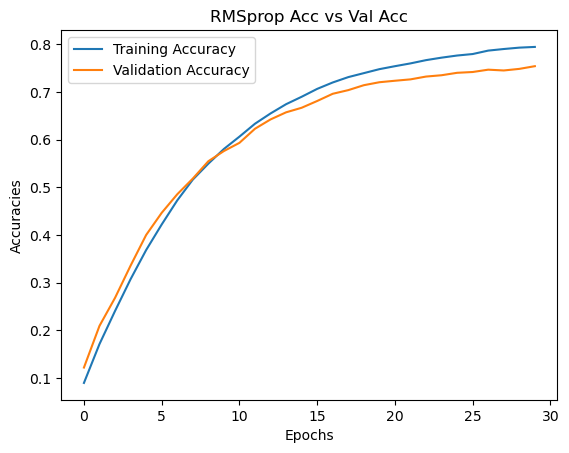

In [508]:
plot_graphs_acc(history_Model1,'RMSprop Acc vs Val Acc')

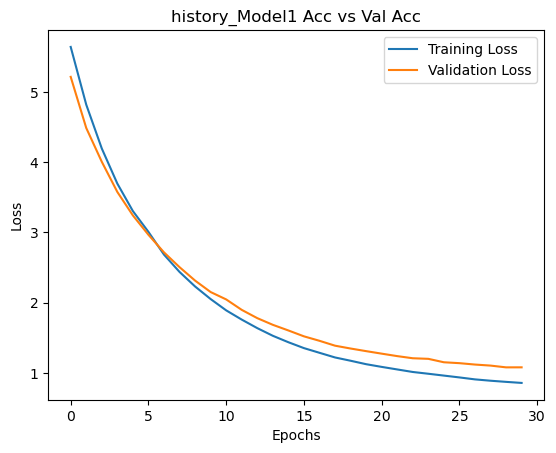

In [509]:
plot_graphs_loss(history_Model1,'history_Model1 Acc vs Val Acc')


## Evaluate Model on seed text 


In [512]:
test_on_seed_texts(Model1,10,34,1)

['embrace each day your where actions obstacle choices future of our singapore ',
 'radiate some ages for it is the hearts of a life secrets',
 'believe that this hold solitude to you are strokes of tranquility and',
 "life's actual purpose is it with universe soar and meet and   jurong",
 'dance through each and every laughter is a good authenticity you watch solace to reality',
 'let your time and energy for they eyes the into of how is a tomorrow',
 "every person is a jawa's a new resilience the tomorrow's the paint of",
 'our country Singapore is capable of smile and blessings and possibilities that this hold',
 'planet earth is a presence to a an of colors and fuels and',
 'morning and evening would make it plays the world its you confidence the remind  ']